In [1]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import re
import os
from PIL import Image
from keras.datasets import mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Conv2D, Dropout, Flatten, UpSampling2D, LeakyReLU, Embedding, Multiply, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar

C:\Users\edgar.dakin\AppData\Local\Continuum\Anaconda3\envs\gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Based on https://arxiv.org/pdf/1610.09585v4.pdf

## Constants

In [2]:
# Generator constants
NUM_DIGIT_CLASSES = 10
NOISE_LAYER_SIZE = 100

# Discriminator constants
IMAGE_SHAPE = (28, 28, 1)

# Training constants
ADAM_LR = 0.00005
ADAM_BETA1 = 0.5
BATCH_SIZE = 100

# Dataset lengths
NX1 = 60000
NX2 = 10000

## Generator

In [9]:
# Create inputs
digit_in = Input(shape=(NUM_DIGIT_CLASSES,), dtype='int32')
noise_in = Input(shape=(NOISE_LAYER_SIZE,), dtype='float32')

# Combine inputs
digit_embed = Embedding(input_dim=NUM_DIGIT_CLASSES, output_dim=NOISE_LAYER_SIZE, embeddings_initializer='glorot_normal')(digit_in)
combined = Multiply()([noise_in, digit_embed])
combined = Flatten()(combined)

# Add layers
gen = Dense(1024)(combined)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('relu')(gen)
gen = Dense(128*7*7)(gen)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('relu')(gen)
gen = Reshape((7, 7, 128))(gen)
gen = UpSampling2D((2, 2))(gen)
gen = Conv2D(256, (5, 5), padding='same', kernel_initializer='glorot_normal')(gen)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('tanh')(gen)
gen = UpSampling2D((2, 2))(gen)
gen = Conv2D(128, (5, 5), padding='same', kernel_initializer='glorot_normal')(gen)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('tanh')(gen)
gen = Conv2D(1, (2, 2), padding='same', kernel_initializer='glorot_normal')(gen)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('tanh')(gen)

# Create and compile model
generator = Model([digit_in, noise_in], gen)
generator.compile(Adam(ADAM_LR, ADAM_BETA1), 'binary_crossentropy')

## Discriminator

In [10]:
# Input
img_in = Input(shape=IMAGE_SHAPE)

# Layers
conv1 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(img_in)
leaky1 = LeakyReLU()(conv1)
dropout1 = Dropout(0.3)(leaky1)
conv2 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(dropout1)
leaky2 = LeakyReLU()(conv2)
dropout2 = Dropout(0.3)(leaky2)
conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(dropout2)
leaky3 = LeakyReLU()(conv3)
dropout3 = Dropout(0.3)(leaky3)
conv4 = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(dropout3)
leaky4 = LeakyReLU()(conv4)
dropout4 = Dropout(0.3)(leaky4)
flatten1 = Flatten()(dropout4)

# Outputs
is_real = Dense(1, activation='sigmoid', name='is_it_real')(flatten1)
which_class = Dense(10, activation='softmax', name='predicted_label')(flatten1)

# Create and compile model
discriminator = Model(img_in, [is_real, which_class])
discriminator.compile(Adam(ADAM_LR, ADAM_BETA1), ['binary_crossentropy', 'categorical_crossentropy'])

## Combined Model

In [11]:
# Inputs
digit_in = Input(shape=(NUM_DIGIT_CLASSES,), dtype='int32')
noise_in = Input(shape=(NOISE_LAYER_SIZE,), dtype='float32')

# Network structure
fake = generator([digit_in, noise_in])
discriminator.trainable = False
is_real, which_class = discriminator(fake)

# Compilation
combined = Model([digit_in, noise_in], [is_real, which_class])
combined.compile(Adam(ADAM_LR, ADAM_BETA1), ['binary_crossentropy', 'categorical_crossentropy'])

## Import MNIST

In [12]:
(x1, y1), (x2, y2) = mnist.load_data()
x_train = (x1.astype(np.float32)/127.5 - 1).reshape((NX1, 28, 28, 1))
x_test = (x2.astype(np.float32)/127.5 - 1).reshape((NX2, 28, 28, 1))
y_train = pd.get_dummies(y1).values
y_test = pd.get_dummies(y2).values

In [13]:
def expand_labels(labels):
    labels = pd.get_dummies(labels)
    if labels.columns.shape[0] != 10:
        for col in range(10):
            if col not in list(labels.columns):
                labels[col] = 0
    return labels.values

## Training

In [15]:
EPOCHS = 250
num_batches = int(NX1/BATCH_SIZE)
gen_train_losses, disc_train_losses, disc_test_losses = [], [], []

In [ ]:
for ep in range(EPOCHS):
    print('Epoch {0} of {1}:'.format(ep+1, EPOCHS))
    progress_bar = Progbar(target=num_batches)
    generator_loss, discriminator_loss = [], []

    for ix in range(num_batches):

        # Generate noise, sample and process labels
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, NOISE_LAYER_SIZE))
        rand_labels = expand_labels(np.random.randint(0, 10, BATCH_SIZE))

        # Select training images and labels
        imgs = x_train[ix*BATCH_SIZE: (ix+1)*BATCH_SIZE]
        labs = y_train[ix*BATCH_SIZE: (ix+1)*BATCH_SIZE]

        fake_images = generator.predict([rand_labels, noise])

        full_imgs = np.concatenate((imgs, fake_images), axis=0)
        full_real = np.array([1]*BATCH_SIZE + [0]*BATCH_SIZE)
        full_labs = np.concatenate((labs, rand_labels), axis=0)

        discriminator_loss.append(discriminator.train_on_batch(full_imgs, [full_real, full_labs]))

        double_noise = np.random.uniform(-1, 1, (2*BATCH_SIZE, NOISE_LAYER_SIZE))
        double_rand_labels = expand_labels(np.random.randint(0, 10, 2*BATCH_SIZE))
        full_trick = np.ones(2*BATCH_SIZE)

        generator_loss.append(combined.train_on_batch([double_rand_labels, double_noise],
                                                      [full_trick, double_rand_labels]))

        progress_bar.update(ix)

    # Testing
    test_noise = np.random.uniform(-1, 1, (NX2, NOISE_LAYER_SIZE))
    test_labels = expand_labels(np.random.randint(0, 10, NX2))
    test_imgs = generator.predict([test_labels, test_noise])

    full_test = np.concatenate((x_test, test_imgs), axis=0)
    full_is_real = np.array([1]*NX2 + [0]*NX2)
    full_labels = np.concatenate((y_test, test_labels), axis=0)

    dte = discriminator.evaluate(full_test, [full_is_real, full_labels], verbose=0)
    disc_test_losses.append(dte)
    gen_train_losses.append(np.mean(generator_loss))
    dtr = list(np.array(discriminator_loss).mean(axis=0))
    disc_train_losses.append(dtr)
    
    print('\nGenerator training loss: {0:0.5f}'.format(gen_train_losses[-1]))
    print('Discriminator:    Total  | Real/Fake | Classifier')
    print('Training losses: {0:0.5f} |  {1:0.5f}  | {2:0.5f}'.format(dte[0], dte[1], dte[2]))
    print('Testing  losses: {0:0.5f} |  {1:0.5f}  | {2:0.5f}'.format(dtr[0], dtr[1], dtr[2]))
    print('-'*58)

Epoch 1 of 250:


C:\Users\edgar.dakin\AppData\Local\Continuum\Anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


599/600 [============================>.] - ETA: 0ss15 
Generator training loss: 3.27267
Discriminator training losses: 0.25624 | 0.00171 | 0.25453
Discriminator testing  losses: 0.97094 | 0.09890 | 0.87204
----------------------------------------------------------
Epoch 2 of 250:
599/600 [============================>.] - ETA: 0ss
Generator training loss: 4.32496
Discriminator training losses: 0.19070 | 0.00068 | 0.19002
Discriminator testing  losses: 0.28827 | 0.00273 | 0.28555
----------------------------------------------------------
Epoch 3 of 250:
599/600 [============================>.] - ETA: 0ss
Generator training loss: 4.78481
Discriminator training losses: 0.22019 | 0.04165 | 0.17854
Discriminator testing  losses: 0.27404 | 0.02335 | 0.25069
----------------------------------------------------------
Epoch 4 of 250:
599/600 [============================>.] - ETA: 0ss
Generator training loss: 4.97496
Discriminator training losses: 1.60614 | 1.34676 | 0.25938
Discriminator testi

## Save Trained Models

In [2]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')
combined.save('combined.h5')

NameError: name 'generator' is not defined

## Load Saved Model

In [3]:
generator = load_model('generator.h5')

## Training Plots

In [72]:
plt.rcParams['figure.figsize'] = (8, 5)

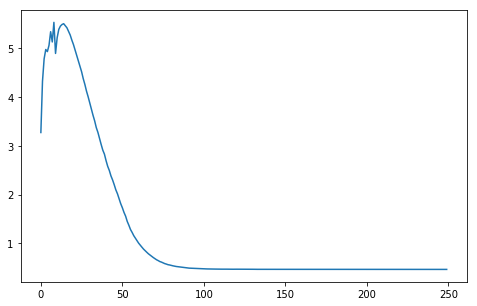

In [73]:
plt.plot(range(250), gen_train_losses)
plt.show()

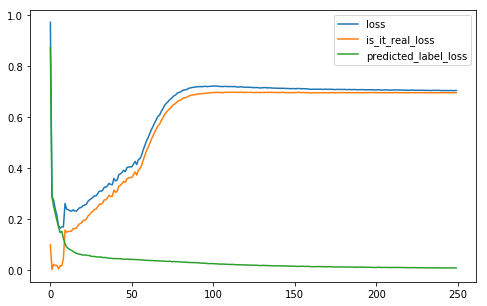

In [76]:
plt.plot(range(250), disc_train_losses)
plt.legend(discriminator.metrics_names)
plt.show()

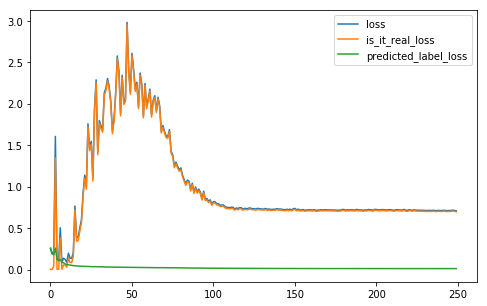

In [77]:
plt.plot(range(250), disc_test_losses)
plt.legend(discriminator.metrics_names)
plt.show()

## Digit Visualisation Widgets

In [4]:
def generate_digit(digit, mu, sigma):
    plt.figure(2)
    dig = np.zeros(10)
    dig[digit] = 1
    features = np.random.normal(mu, sigma, (100,)).clip(-1, 1)
    arr = generator.predict([dig.reshape(1, -1), features.reshape(1, -1)]).squeeze()
    img = Image.fromarray((arr + 1) * 127.5)
    plt.imshow(img)

interactive_plot = interactive(generate_digit, digit=(0, 9, 1), mu=(-1, 1, 0.05), sigma=(0, 1, 0.05))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=4, description='digit', max=9), FloatSlider(value=0.0, description='mu',…

In [5]:
# Good elements to experiment with
# 4: 1, 4, 10, 23, 29, 34, 63, 82

def generate_digit_single_change(digit, default, element, value):
    """Sets all 100 values in noise to be 'default', except at index 'element' where it is set to 'value'."""
    plt.figure(2)
    dig = np.zeros(10)
    dig[digit] = 1
    features = np.ones(100)*default
    features[element] = value
    arr = generator.predict([dig.reshape(1, -1), features.reshape(1, -1)]).squeeze()
    img = Image.fromarray((arr + 1) * 127.5)
    plt.imshow(img)

interactive_plot = interactive(generate_digit_single_change, digit=(0, 9, 1), 
                               default=(-1, 1, 0.05), element=(0, 99, 1), value=(-1, 1, 0.05))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=4, description='digit', max=9), FloatSlider(value=0.0, description='defa…

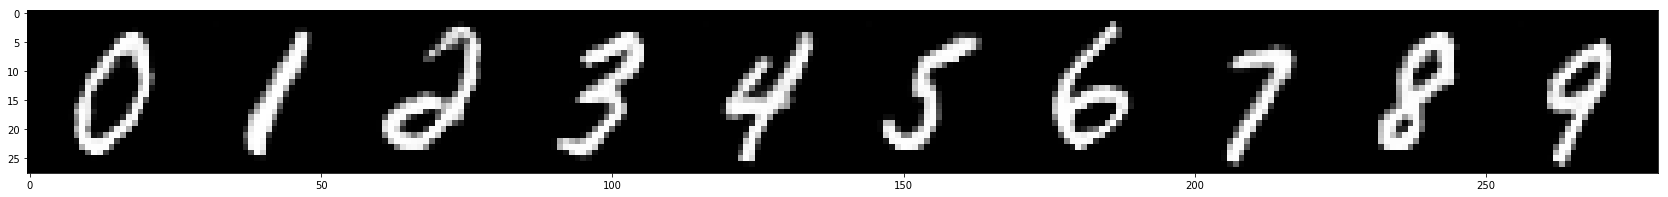

In [44]:
tt = generator.predict([np.eye(10), np.ones((10, 100))*-0.2])
ttlist = [tt[i,:,:,:].squeeze() for i in range(10)]
ttall = np.concatenate(ttlist, axis=1)
ttadj = (ttall + 1) * 127.5
ttallimg = Image.fromarray(ttadj)
plt.rcParams['figure.figsize'] = (30, 3)
plt.imshow(ttallimg)

## Output Visualisation

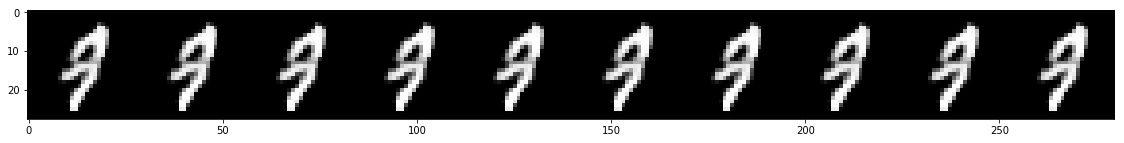

In [78]:
og_imgs = generator.predict([og_labels, np.zeros((10, 100))])
og_img_list = [og_imgs[i,:,:,:].squeeze() for i in range(10)]
og_all = np.concatenate(og_img_list, axis=1)
og_img = Image.fromarray((og_all + 1)*127.5)
plt.rcParams['figure.figsize'] = (20, 2)
plt.imshow(og_img)

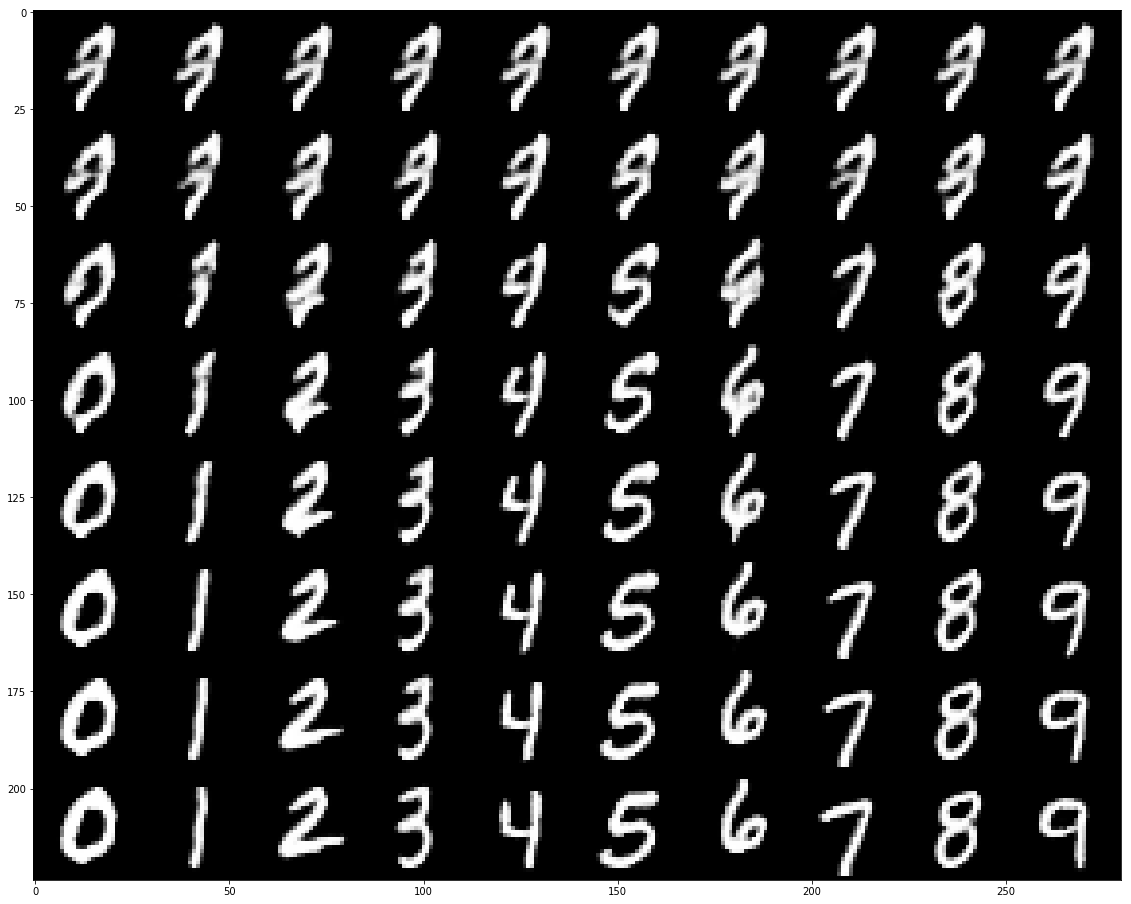

In [103]:
og_imgs_list = []
for const in range(8):
    og_imgs = generator.predict([og_labels, const*0.05*np.ones((10, 100))])
    og_img_list = [og_imgs[i,:,:,:].squeeze() for i in range(10)]
    og_all = np.concatenate(og_img_list, axis=1)
    og_imgs_list.append(og_all)
og_final = np.concatenate(og_imgs_list, axis=0)
og_img = Image.fromarray((og_final + 1)*127.5)
plt.rcParams['figure.figsize'] = (20, 16)
plt.imshow(og_img)

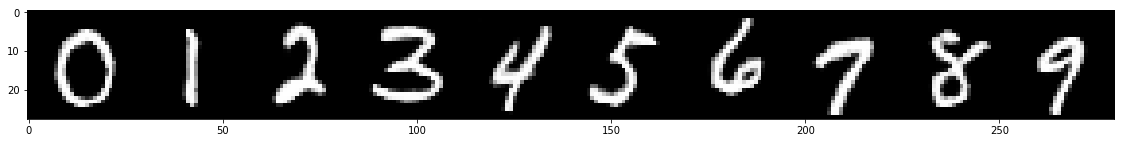

In [50]:
og_imgs = generator.predict([np.eye(10), np.random.uniform(-1, 1, (10, 100))])
og_img_list = [og_imgs[i,:,:,:].squeeze() for i in range(10)]
og_all = np.concatenate(og_img_list, axis=1)
og_img = Image.fromarray((og_all + 1)*127.5)
plt.rcParams['figure.figsize'] = (20, 2)
plt.imshow(og_img)

In [15]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 100)      1000        input_1[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 10, 100)      0           input_2[0][0]                    
                                                                 embedding_1[0][0]                
__________

In [59]:
digits, noise, embed = generator.layers[0], generator.layers[1], generator.layers[2]

In [63]:
noise_embed = embed

In [64]:
# Create inputs
digit_in = Input(shape=(NUM_DIGIT_CLASSES,), dtype='int32', weights=generator.layers[0].weights)
noise_in = Input(shape=(NOISE_LAYER_SIZE,), dtype='float32', weights=generator.layers[1].weights)

TypeError: Input() got an unexpected keyword argument 'weights'

In [ ]:
# Create inputs
digit_in = Input(shape=(NUM_DIGIT_CLASSES,), dtype='int32')
noise_in = Input(shape=(NOISE_LAYER_SIZE,), dtype='float32')

# Combine inputs
digit_embed = Embedding(input_dim=NUM_DIGIT_CLASSES, output_dim=NOISE_LAYER_SIZE, embeddings_initializer='glorot_normal')(digit_in)
combined = Multiply()([noise_in, digit_embed])
combined = Flatten()(combined)

# Add layers
gen = Dense(1024)(combined)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('relu')(gen)
gen = Dense(128*7*7)(gen)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('relu')(gen)
gen = Reshape((7, 7, 128))(gen)
gen = UpSampling2D((2, 2))(gen)
gen = Conv2D(256, (5, 5), padding='same', kernel_initializer='glorot_normal')(gen)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('tanh')(gen)
gen = UpSampling2D((2, 2))(gen)
gen = Conv2D(128, (5, 5), padding='same', kernel_initializer='glorot_normal')(gen)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('tanh')(gen)
gen = Conv2D(1, (2, 2), padding='same', kernel_initializer='glorot_normal')(gen)
gen = BatchNormalization(momentum=0.9)(gen)
gen = Activation('tanh')(gen)

# Create and compile model
generator = Model([digit_in, noise_in], gen)
generator.compile(Adam(ADAM_LR, ADAM_BETA1), 'binary_crossentropy')

In [65]:
import h5py

In [82]:
th5 = h5py.File('generator.h5', 'r')

In [83]:
list(th5.keys())

['model_weights']

In [84]:
list(th5['model_weights'].keys())

['activation_1',
 'activation_2',
 'activation_3',
 'activation_4',
 'activation_5',
 'batch_normalization_1',
 'batch_normalization_2',
 'batch_normalization_3',
 'batch_normalization_4',
 'batch_normalization_5',
 'conv2d_1',
 'conv2d_2',
 'conv2d_3',
 'dense_1',
 'dense_2',
 'embedding_1',
 'flatten_1',
 'input_1',
 'input_2',
 'multiply_1',
 'reshape_1',
 'up_sampling2d_1',
 'up_sampling2d_2']

In [91]:
dense1 = th5['model_weights']['dense_1']['dense_1']['kernel:0']
dense2 = th5['model_weights']['dense_2']['dense_2']['kernel:0']

In [92]:
dense2

<HDF5 dataset "kernel:0": shape (1024, 6272), type "<f4">